In [17]:
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import kagglehub
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models



 # Download Data

In [18]:
data_dir = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", data_dir)

Path to dataset files: /home/josiah/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [19]:
data_dir = '/home/josiah/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1'
images_dir = os.path.join(data_dir, "Images")
captions_file = os.path.join(data_dir, "captions.txt")

In [20]:
glove_dir = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")
print("Path to dataset files:", glove_dir)

Path to dataset files: /home/josiah/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1


In [21]:
glove_dir = '/home/josiah/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1'
glove_file = os.path.join(glove_dir, "glove.6B.100d.txt")

# Data Processing

In [22]:
dataset = pd.read_csv(captions_file)
dataset.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [23]:
dataset['caption'] = dataset['caption'].apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x.lower().strip()))
dataset.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1               a girl going into a wooden building   
2    a little girl climbing into a wooden playhouse   
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...

In [24]:
shuffled_image_names = pd.Series(dataset['image'].unique()).sample(frac=1, random_state=42)

In [25]:
num_images = len(shuffled_image_names)
train_imgs_filenames = shuffled_image_names[:int(num_images*0.6)]
validate_imgs_filenames = shuffled_image_names[int(num_images*0.6):int(num_images*0.8)]
test_imgs_filenames = shuffled_image_names[int(num_images*0.8):]

train_imgs = dataset.loc[dataset['image'].isin(train_imgs_filenames), :]
validate_imgs = dataset.loc[dataset['image'].isin(validate_imgs_filenames), :]
test_imgs = dataset.loc[dataset['image'].isin(test_imgs_filenames), :]

print(f'Total images: {num_images}')
print(f'Training images: {len(train_imgs_filenames)}')
print(f'Validation images: {len(validate_imgs_filenames)}')
print(f'Testing images: {len(test_imgs_filenames)}')

Total images: 8091
Training images: 4854
Validation images: 1618
Testing images: 1619


## Build Vocabulary

In [26]:
word_counter = Counter()

# use only the training data
for _, row in train_imgs.iterrows():
    word_counter.update(row['caption'].split())

vocab_words = list(word_counter.keys())
# Add special tokens
vocab = ["<PAD>", "<START>", "<END>", "<UNK>"] + vocab_words
vocab_size = len(vocab)
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 6993


In [27]:
embedding_dim = 100  # using 100d GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype=np.float32)
# For words not found in GloVe, we will keep the row as zeros (or could randomize)
found_words = 0
with open(glove_file, 'r', encoding='utf8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        if word in word2idx:
            idx = word2idx[word]
            embedding_matrix[idx] = vec
            found_words += 1
print(f"Found {found_words} words in GloVe out of {vocab_size}")

Found 6363 words in GloVe out of 6993


In [28]:
class FlickrDataset(Dataset):
    def __init__(self, dataset_df, word2idx, transform=None, max_length=25, mode="train"):

        self.filenames = list(dataset_df['image'].unique())
        self.captions = dataset_df.groupby('image')['caption'].apply(list).to_dict()
        self.word2idx = word2idx
        self.transform = transform
        self.max_length = max_length
        self.mode = mode

        # In training mode, we'll treat each (image, caption) as separate entries for more variation
        if mode == "train":
            self.pairs = dataset_df.values.tolist()
        else:
            # In validation/test, we may just use one caption per image for evaluation or all for metrics
            self.pairs = [(fname, self.captions[fname][0]) for fname in self.filenames]  # using first caption
            # (We will handle multiple references in evaluation separately)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        fname, caption = self.pairs[idx]
        # Load and transform image
        img_path = os.path.join(images_dir, fname)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Encode caption to tensor of word indices
        tokens = caption.split()
        # Truncate if longer than max_length - 2 (for <START> and <END>)
        if len(tokens) > self.max_length - 2:
            tokens = tokens[:self.max_length-2]
        # Convert words to indices, with <UNK> for unseen
        caption_indices = [word2idx["<START>"]] + \
                          [word2idx.get(word, word2idx["<UNK>"]) for word in tokens] + \
                          [word2idx["<END>"]]
        # Pad to max_length
        if len(caption_indices) < self.max_length:
            caption_indices += [word2idx["<PAD>"]] * (self.max_length - len(caption_indices))
        caption_tensor = torch.tensor(caption_indices, dtype=torch.long)
        return image, caption_tensor

In [29]:
from PIL import Image
import torchvision.transforms as T

# Define image transform pipeline for training (could add augmentation here if desired)
IMG_SIZE = 224

# Evaluation (validation and test) transform pipeline (deterministic)
transforms = T.Compose([
    # Resize image to have the shorter side equal to 256 pixels while preserving aspect ratio
    T.Resize(256),
    # Center crop to the target size
    T.CenterCrop(IMG_SIZE),
    # Convert the PIL Image to a PyTorch Tensor (range [0, 1])
    T.ToTensor(),
    # Normalize using ImageNet parameters
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [30]:
# Instantiate datasets
max_caption_len = 30
train_dataset = FlickrDataset(train_imgs, word2idx, transform=transforms, max_length=max_caption_len, mode="train")
val_dataset   = FlickrDataset(validate_imgs, word2idx, transform=transforms, max_length=max_caption_len, mode="val")
test_dataset  = FlickrDataset(test_imgs, word2idx, transform=transforms, max_length=max_caption_len, mode="test")

# DataLoaders (use shuffle for training, no shuffle for val/test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)  # test one image at a time if we want to examine outputs

# CNN-LSTM

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=256, train_cnn=False, dropout_p=0.5):
        super(EncoderCNN, self).__init__()
        # Load pretrained ResNet50 and remove final fc layer
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)  # PyTorch >=1.12 provides weights like this
        modules = list(resnet.children())[:-1]  # remove last fc layer, keep avgpool
        self.cnn = nn.Sequential(*modules)      # CNN backbone
        self.fc = nn.Linear(resnet.fc.in_features, encoded_image_size)  # learn a transformation to desired dim
        # Freeze CNN weights if not training CNN
        for param in self.cnn.parameters():
            param.requires_grad = train_cnn  # if False, freeze, if True, fine-tune CNN

    def forward(self, images):
        # Expect images of shape (B,3,224,224)
        with torch.no_grad():
            features = self.cnn(images)  # shape (B, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # flatten to (B, 2048)
        features = self.fc(features)  # (B, encoded_image_size)
        features = torch.relu(features)  # activation (optional)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.6):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)
        # Initialize embeddings with GloVe weights
        self.embed.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # (Optionally, freeze embedding weights here by setting requires_grad=False if desired)
        # LSTM to generate captions
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Final output layer to vocab
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        # Linear layers to initialize hidden and cell from encoded image
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)

    def forward(self, features, captions):
        """
        features: tensor (B, hidden_size) from EncoderCNN (encoded image features).
        captions: tensor (B, T) of token indices (including <START> and <END> and padded to length T).
                  We will feed in captions[:, :-1] as input (all but last token).
        """
        batch_size = features.size(0)
        # Initialize LSTM state
        h = self.init_h(features).unsqueeze(0)  # (1, B, hidden_size)
        c = self.init_c(features).unsqueeze(0)  # (1, B, hidden_size)
        # Embed captions
        embeddings = self.embed(captions)  # (B, T, embed_size)
        # We do not need to feed the last <END> token into the LSTM, so we use all except last step
        # (since at last input there is no next output to predict)
        embeddings = embeddings[:, :-1, :]  # (B, T-1, embed_size)
        # LSTM forward
        lstm_out, _ = self.lstm(embeddings, (h, c))  # lstm_out: (B, T-1, hidden_size)
        outputs = self.fc_out(lstm_out)              # (B, T-1, vocab_size)
        return outputs

    def generate_caption(self, features, max_length=20):
        """Generate a caption for an image (greedy search)."""
        # features: (1, hidden_size) for single image
        h = self.init_h(features).unsqueeze(0)
        c = self.init_c(features).unsqueeze(0)
        inputs = torch.tensor([[word2idx["<START>"]]], dtype=torch.long).to(device)  # start token
        caption_indices = []
        for t in range(max_length):
            embedding = self.embed(inputs)  # (1,1,embed_size)
            lstm_out, (h, c) = self.lstm(embedding, (h, c))
            output = self.fc_out(lstm_out.squeeze(1))  # (1, vocab_size)
            _, predicted_idx = output.max(1)  # predicted word index (greedy)
            predicted_idx = predicted_idx.item()
            if predicted_idx == word2idx["<END>"]:
                break
            caption_indices.append(predicted_idx)
            # next input to LSTM is the predicted word
            inputs = torch.tensor([[predicted_idx]], dtype=torch.long).to(device)
        # Convert indices to words, omit <END>
        caption_words = [idx2word[idx] for idx in caption_indices]
        return " ".join(caption_words)

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


Epoch [1/5], Step [100/759], Avg Loss: 5.3091
Total gradient norm: 0.6640
Epoch [1/5], Step [200/759], Avg Loss: 4.3999
Total gradient norm: 0.7330
Epoch [1/5], Step [300/759], Avg Loss: 4.1197
Total gradient norm: 0.6474
Epoch [1/5], Step [400/759], Avg Loss: 3.9001
Total gradient norm: 0.6932
Epoch [1/5], Step [500/759], Avg Loss: 3.7527
Total gradient norm: 0.6614
Epoch [1/5], Step [600/759], Avg Loss: 3.6764
Total gradient norm: 0.5484
Epoch [1/5], Step [700/759], Avg Loss: 3.5873
Total gradient norm: 0.5846
Validation Loss after epoch 1: 3.4829
Epoch [2/5], Step [100/759], Avg Loss: 3.3932
Total gradient norm: 0.6975
Epoch [2/5], Step [200/759], Avg Loss: 3.3622
Total gradient norm: 0.6076
Epoch [2/5], Step [300/759], Avg Loss: 3.3352
Total gradient norm: 0.6452
Epoch [2/5], Step [400/759], Avg Loss: 3.2856
Total gradient norm: 0.6934
Epoch [2/5], Step [500/759], Avg Loss: 3.2483
Total gradient norm: 0.6592
Epoch [2/5], Step [600/759], Avg Loss: 3.2438
Total gradient norm: 0.6819


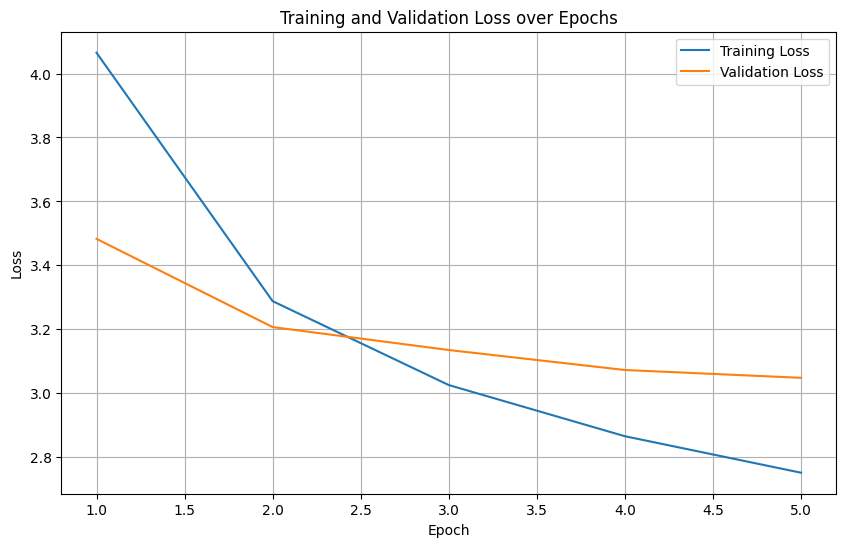

In [33]:
# Initialize models and optimizer
embed_size = 100         # word embedding size (GloVe dim)
hidden_size = 512        # LSTM hidden/cell size
encoder = EncoderCNN(encoded_image_size=hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
# At start, only decoder parameters require grad (encoder CNN is frozen)
params = list(decoder.parameters()) + list(encoder.fc.parameters())  # include encoder.fc so it can learn to map features

optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<PAD>"])

# Training loop
num_epochs = 5  # (For real training, more epochs, e.g., 20; but can adjust)
print_every = 100  # print loss every 100 batches

train_epoch_losses = []
val_epoch_losses = []
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0.0
    num_batches = 0
    running_loss = 0.0
    
    for batch_idx, (images, captions) in enumerate(train_loader):
        images, captions = images.to(device), captions.to(device)
        optimizer.zero_grad()
        # Forward pass
        features = encoder(images)                 # (B, hidden_size)
        outputs = decoder(features, captions)      # (B, T-1, vocab_size)
        # Prepare target: captions[:, 1:] (ignore <START> for target)
        targets = captions[:, 1:].to(device)       # (B, T-1)
        # Flatten outputs and targets to compute loss
        outputs = outputs.view(-1, vocab_size)     # ((B*(T-1)), vocab_size)
        targets = targets.contiguous().view(-1)    # ((B*(T-1)))
        loss = criterion(outputs, targets)
        # Backpropagate
        loss.backward()
        optimizer.step()

        total_grad_norm = 0.0
        for param in list(decoder.parameters()) + list(encoder.fc.parameters()):
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2)
                total_grad_norm += grad_norm.item() ** 2
        
        running_loss += loss.item()
        total_loss += loss.item()
        num_batches += 1
        
        if (batch_idx + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Avg Loss: {avg_loss:.4f}")
            running_loss = 0.0

            total_grad_norm = total_grad_norm ** 0.5
            print(f"Total gradient norm: {total_grad_norm:.4f}")
            optimizer.step()

    # Calculate average training loss for this epoch (over all batches)
    avg_train_loss = total_loss / num_batches if num_batches > 0 else 0
    train_epoch_losses.append(avg_train_loss)

    encoder_checkpoint_path = f"model/encoder_epoch_{epoch+1}.pth"
    decoder_checkpoint_path = f"model/decoder_lstm_epoch_{epoch+1}.pth"
    torch.save(encoder.state_dict(), encoder_checkpoint_path)
    torch.save(decoder.state_dict(), decoder_checkpoint_path)
    
    # --------------------------------------------------------------------------
    # Validation for this epoch
    # --------------------------------------------------------------------------
    decoder.eval()
    encoder.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions)
            targets = captions[:, 1:].contiguous().view(-1)
            outputs = outputs.view(-1, vocab_size)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches if val_batches > 0 else 0
    val_epoch_losses.append(avg_val_loss)
    
    print(f"Validation Loss after epoch {epoch+1}: {avg_val_loss:.4f}")

# --------------------------------------------------------------------------
# Plotting the training and validation loss curves
# --------------------------------------------------------------------------
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_epoch_losses, label="Training Loss")
plt.plot(epochs, val_epoch_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


torch.Size([1, 512])
Answer <START> a man lays on a bench while his dog sits by him <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


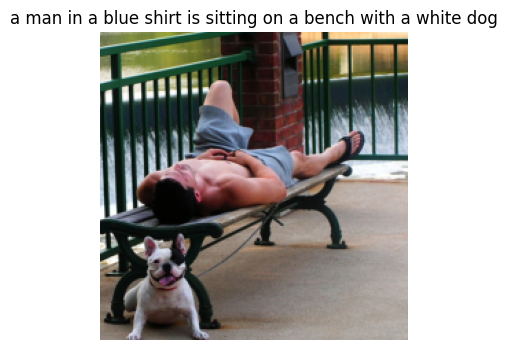

torch.Size([1, 512])
Answer <START> a man in an orange hat starring at something <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


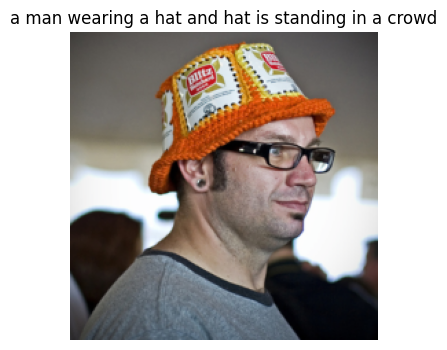

torch.Size([1, 512])
Answer <START> a child playing on a rope net <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


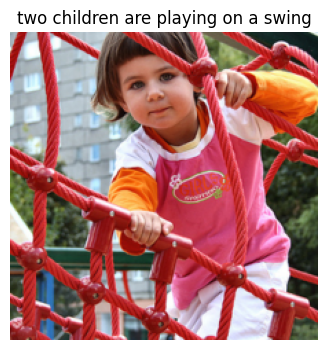

torch.Size([1, 512])
Answer <START> a black dog leaps over a log <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


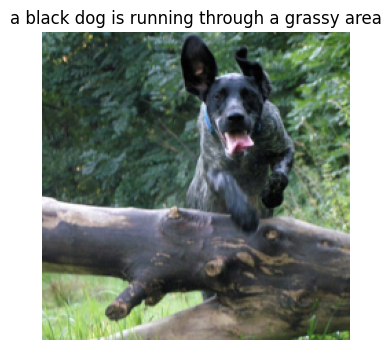

torch.Size([1, 512])
Answer <START> a child and a woman are at waters edge in a big city <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


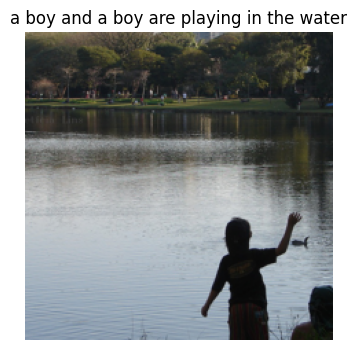

torch.Size([1, 512])
Answer <START> a person eats <UNK> while watching a small television <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


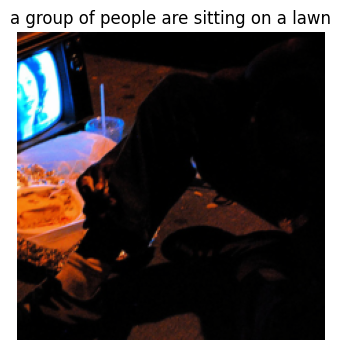

torch.Size([1, 512])
Answer <START> a crowd watching air balloons at night <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


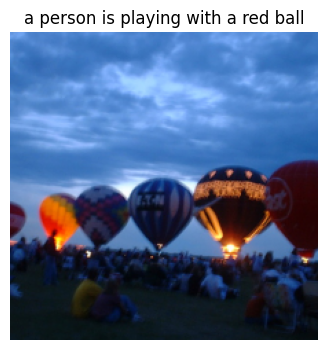

torch.Size([1, 512])
Answer <START> a child with a helmet on his head rides a bike <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


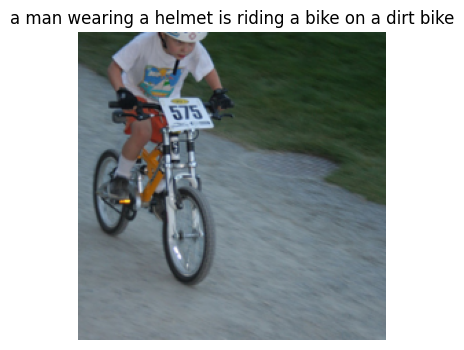

torch.Size([1, 512])
Answer <START> a lady and a man with no shirt sit on a dock <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


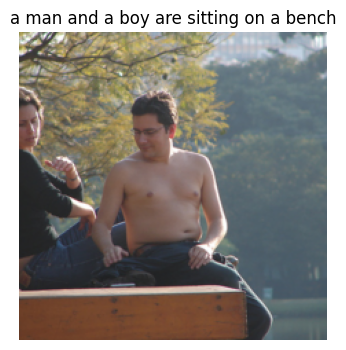

torch.Size([1, 512])
Answer <START> a woman in a yellow shirt and green shorts is climbing an artificial red wall whilst wearing a safety harness <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


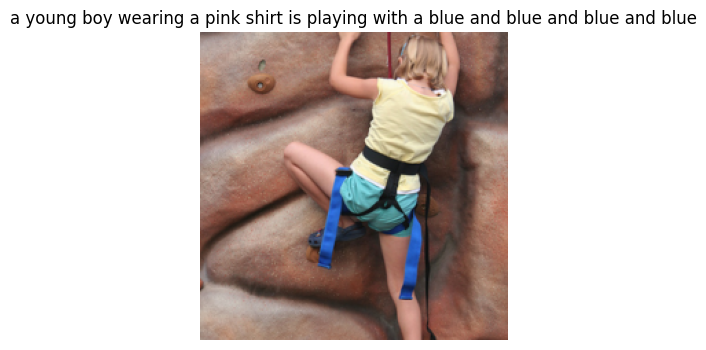

torch.Size([1, 512])
Answer <START> people stand inside a rock dome <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


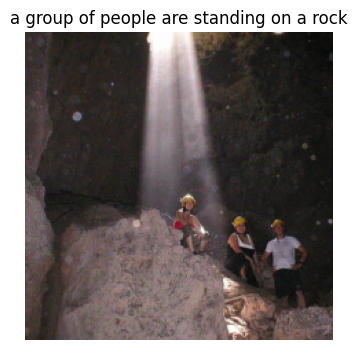

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to de-normalize an image tensor for visualization.
def im_convert(tensor):
    """
    Convert an image tensor (normalized) into a NumPy array for visualization.
    Assumes image normalization with:
       mean = [0.485, 0.456, 0.406]
       std  = [0.229, 0.224, 0.225]
    """
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Set models to evaluation mode
encoder.eval()
decoder.eval()
num_to_display = 10
i = 0
test_images = []
# Get the first batch from the test loader
with torch.no_grad():
    for batch in test_loader:
        if i > num_to_display:
            break 
        test_image, caption = batch
        img_tensor = test_image.to(device)  # shape (1, 3, 224, 224)
        # Generate caption using the decoder's generate_caption() method
        features = encoder(img_tensor)
        print(features.shape)
        generated_caption = decoder.generate_caption(features,max_length=30)
    
        # Convert the image tensor to NumPy for display
        image_np = im_convert(img_tensor)

        # print actual answer
        caption_words = [idx2word[idx] for idx in caption[0].tolist()]
        print(f'Answer {" ".join(caption_words)}')
        # Visualize the image with the generated caption as the title
        plt.figure(figsize=(6, 4))
        plt.imshow(image_np)
        plt.title(generated_caption)
        plt.axis("off")
        plt.show()
        
        i+=1



# Vison Transformer

In [32]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor, get_scheduler
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set configuration parameters (if needed)
model.config.max_length = 20          # Maximum caption length
model.config.num_beams = 4            # Beam search width (if using beam search)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.1"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

In [34]:
class FlickrDataset(Dataset):
    def __init__(self, dataset_df, tokenizer, transform=None, max_length=25, mode="train"):
        """
        Args:
            dataset_df (pd.DataFrame): DataFrame with at least "image" and "caption" columns.
            tokenizer: A HuggingFace tokenizer instance to tokenize captions.
            transform: Optional torchvision transforms to apply to images.
            max_length (int): Maximum tokenized caption length (including special tokens).
            mode (str): "train" or "val"/"test". In train mode, each image-caption pair is considered;
                        otherwise, one caption per image is used.
        """
        # List of unique image filenames
        self.filenames = list(dataset_df['image'].unique())
        # Group all captions per image into a dictionary: filename -> [list of captions]
        self.captions = dataset_df.groupby('image')['caption'].apply(list).to_dict()
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length
        self.mode = mode

        # For training, use all image-caption pairs for more variation.
        if mode == "train":
            self.pairs = []
            for fname, caps in self.captions.items():
                for cap in caps:
                    self.pairs.append((fname, cap))
        else:
            # For validation/test, use only the first caption per image.
            self.pairs = [(fname, self.captions[fname][0]) for fname in self.filenames]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        fname, caption = self.pairs[idx]
        # Construct the full path to the image.
        img_path = os.path.join(images_dir, fname)
        # Load the image and convert to RGB.
        image = Image.open(img_path).convert('RGB')
        # Apply any provided transforms.
        if self.transform:
            image = self.transform(image)
            
        # Use the tokenizer to tokenize and pad the caption.
        # The tokenizer handles truncation and padding up to max_length.
        tokenized = self.tokenizer(
            caption,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        # Remove the extra batch dimension that the tokenizer returns.
        labels = tokenized.input_ids.squeeze(0)
        # Optionally: Replace padding token IDs with -100 so they are ignored in loss calculation.
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        # Return a dictionary compatible with VisionEncoderDecoderModel inputs.
        return {"pixel_values": image, "labels": labels}


/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1666: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


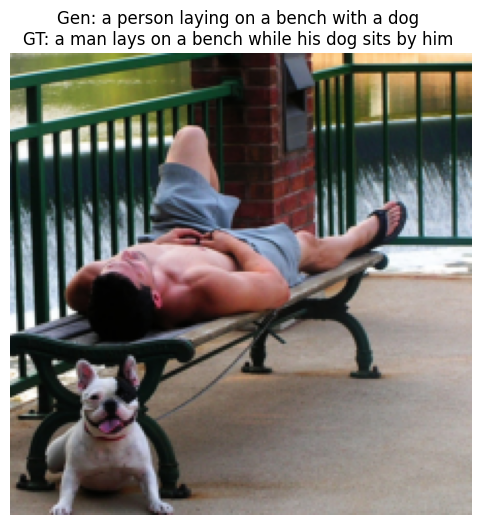

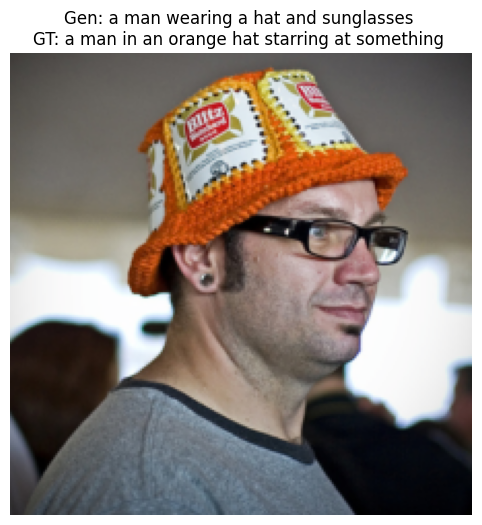

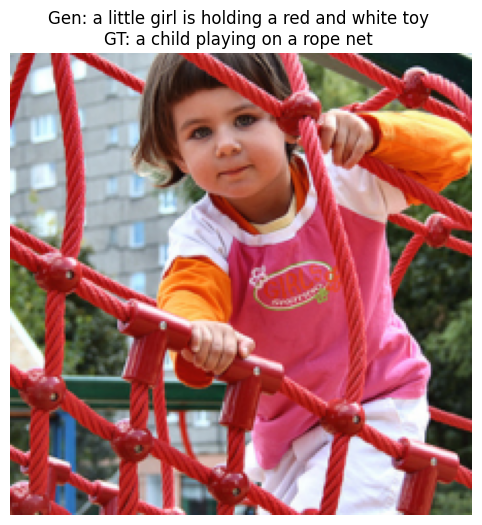

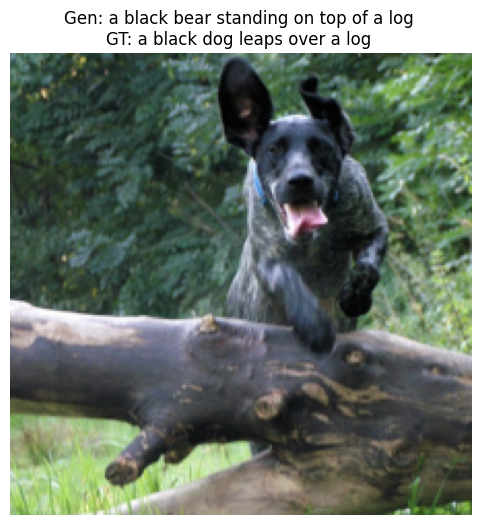

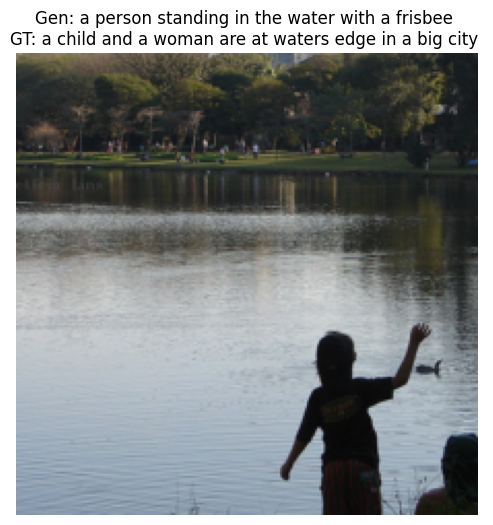

In [35]:
def im_convert(image_tensor):
    """
    Convert a normalized image tensor to a NumPy array suitable for displaying with matplotlib.
    Assumes image normalization with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    """
    image_tensor = image_tensor.cpu().clone().detach().squeeze(0)
    image_np = image_tensor.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    return image_np

# Set the model to evaluation mode
model.eval()
num = 0
with torch.no_grad():
    # Get one batch from the train DataLoader (or change to your validation/test loader)
    for batch in test_loader:
        # Move pixel_values and labels to device.
        pixel_values = batch["pixel_values"].to(device)  # shape: (B, C, H, W)
        labels = batch["labels"].to(device)              # shape: (B, max_length)
        
        # Generate captions using the model's generate() method.
        generated_ids = model.generate(pixel_values,
                                       max_length=model.config.max_length,
                                       num_beams=model.config.num_beams)
        generated_captions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Prepare ground truth captions: Replace -100 with pad_token_id for decoding.
        gt_labels = labels.clone()
        gt_labels[gt_labels == -100] = tokenizer.pad_token_id
        ground_truth_captions = tokenizer.batch_decode(gt_labels, skip_special_tokens=True)
        
        # Loop through each image in the batch.
        for i in range(len(generated_captions)):
            # Extract the i-th image tensor and de-normalize it for display.
            image_tensor = pixel_values[i:i+1]
            image_np = im_convert(image_tensor)
            
            # Get the generated and ground truth captions.
            gen_caption = generated_captions[i]
            gt_caption = ground_truth_captions[i]
            
            # Display the image with both captions.
            plt.figure(figsize=(8, 6))
            plt.imshow(image_np)
            plt.title(f"Gen: {gen_caption}\nGT: {gt_caption}", fontsize=12)
            plt.axis("off")
            plt.show()
        
        num +=1
        if num >=5:
            break

In [23]:
# Instantiate datasets
max_caption_len = 30
train_dataset = FlickrDataset(train_imgs, tokenizer, transform=transforms, max_length=max_caption_len, mode="train")
val_dataset   = FlickrDataset(validate_imgs, tokenizer, transform=transforms, max_length=max_caption_len, mode="val")
test_dataset  = FlickrDataset(test_imgs, tokenizer, transform=transforms, max_length=max_caption_len, mode="test")

# DataLoaders (use shuffle for training, no shuffle for val/test)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [29]:
import torch
from transformers import get_scheduler
from tqdm import tqdm

# Set your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume your model, feature_extractor, and tokenizer are already set up as follows:
# model_name = "nlpconnect/vit-gpt2-image-captioning"
# model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
# feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)
#
# model.config.max_length = 20          
# model.config.num_beams = 4            
# model.config.decoder_start_token_id = tokenizer.bos_token_id
# model.config.eos_token_id = tokenizer.eos_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

# Initialize the optimizer: using standard Adam optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Specify number of epochs
num_epochs = 3
# Calculate total number of training steps
num_training_steps = num_epochs * len(train_loader)

# Create a learning rate scheduler (optional)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,  # Adjust if needed
    num_training_steps=num_training_steps
)

# Set the model to training mode
model.train()

# Create a progress bar for monitoring training steps
progress_bar = tqdm(range(num_training_steps))

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for batch in train_loader:
        # Each batch should include the necessary inputs: images and text data
        pixel_values = batch["pixel_values"].to(device)
        # Tokenized inputs for the caption text
        input_ids = batch["labels"].to(device)
        # Optionally, if your batch contains an attention_mask, move it to the same device
        attention_mask = batch.get("attention_mask")
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)
        # The target labels for language modeling (typically matching input_ids)
        labels = batch["labels"].to(device)

        # Forward pass: compute the outputs and loss from the model
        outputs = model(pixel_values=pixel_values, labels=labels, decoder_attention_mask=attention_mask)
        loss = outputs.loss

        # Zero out the gradients from previous iteration
        optimizer.zero_grad()
        # Backward pass: compute gradients of the loss with respect to parameters
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Step the learning rate scheduler for the next iteration
        lr_scheduler.step()

        # Update progress bar
        progress_bar.update(1)

    # Optionally, output training loss for the current epoch
    print(f"Loss after epoch {epoch+1}: {loss.item():.4f}")



  0%|          | 0/2277 [00:36<?, ?it/s]

Epoch 1/3



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
 33%|███▎      | 759/2277 [20:18<35:13,  1.39s/it]  

Loss after epoch 1: 3.4868
Epoch 2/3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
 67%|██████▋   | 1518/2277 [39:11<17:36,  1.39s/it]

Loss after epoch 2: 3.3698
Epoch 3/3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 2277/2277 [58:03<00:00,  1.39s/it]

Loss after epoch 3: 2.8533


In [30]:
save_directory = "model/trained_vit_gpt2_captioning_model"

# Save the model (configuration and weights)
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'num_beams': 4}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('model/trained_vit_gpt2_captioning_model/tokenizer_config.json',
 'model/trained_vit_gpt2_captioning_model/special_tokens_map.json',
 'model/trained_vit_gpt2_captioning_model/vocab.json',
 'model/trained_vit_gpt2_captioning_model/merges.txt',
 'model/trained_vit_gpt2_captioning_model/added_tokens.json',
 'model/trained_vit_gpt2_captioning_model/tokenizer.json')

/home/josiah/Image-Captioning/.venv/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:670: UserWarning: `num_beams` is set to None - defaulting to 1.
  warnings.warn("`num_beams` is set to None - defaulting to 1.", UserWarning)


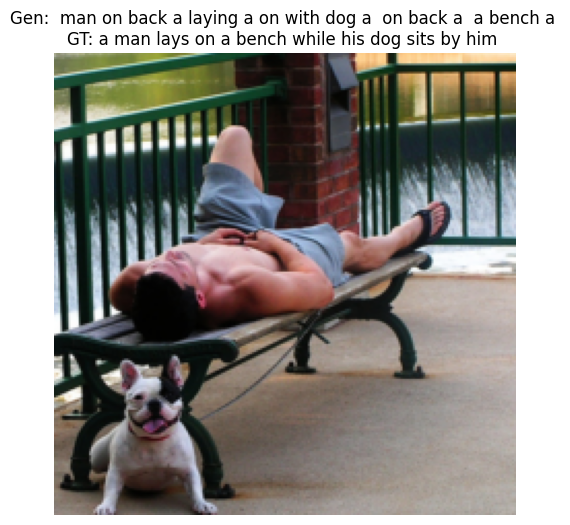

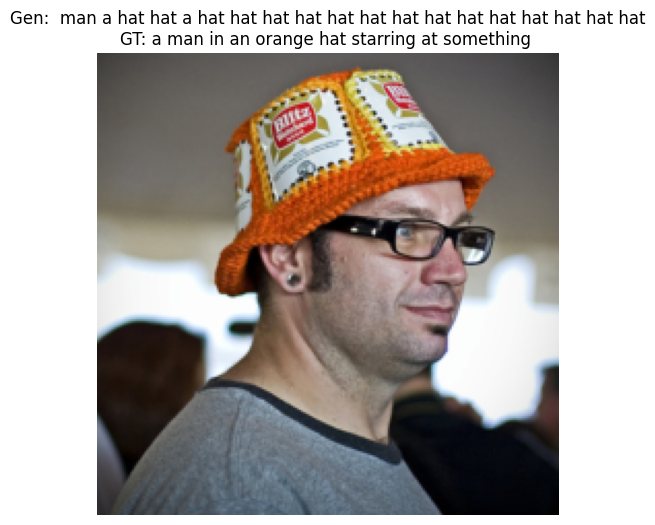

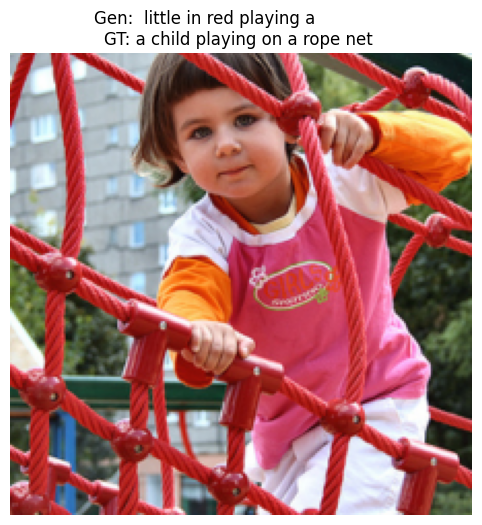

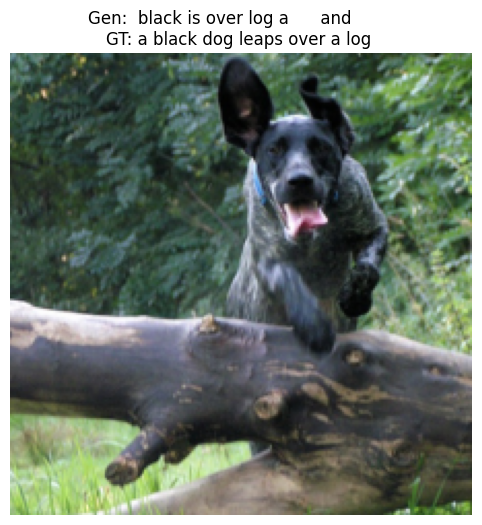

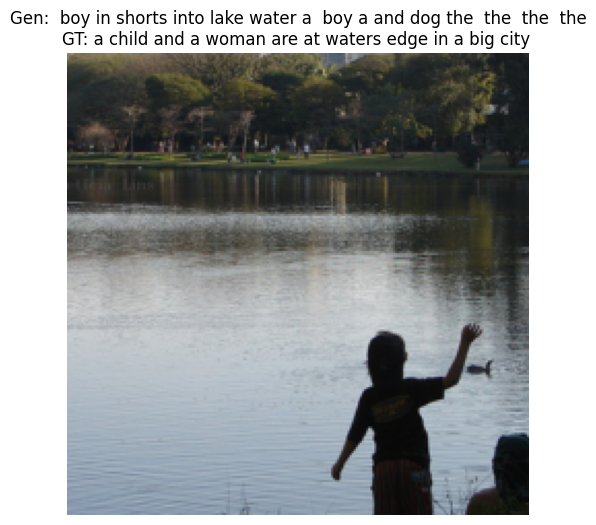

In [31]:
def im_convert(image_tensor):
    """
    Convert a normalized image tensor to a NumPy array suitable for displaying with matplotlib.
    Assumes image normalization with mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    """
    image_tensor = image_tensor.cpu().clone().detach().squeeze(0)
    image_np = image_tensor.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)
    return image_np

# Set the model to evaluation mode
model.eval()
num = 0
with torch.no_grad():
    # Get one batch from the train DataLoader (or change to your validation/test loader)
    for batch in test_loader:
        # Move pixel_values and labels to device.
        pixel_values = batch["pixel_values"].to(device)  # shape: (B, C, H, W)
        labels = batch["labels"].to(device)              # shape: (B, max_length)
        
        # Generate captions using the model's generate() method.
        generated_ids = model.generate(pixel_values,
                                       max_length=model.config.max_length,
                                       num_beams=model.config.num_beams)
        generated_captions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        # Prepare ground truth captions: Replace -100 with pad_token_id for decoding.
        gt_labels = labels.clone()
        gt_labels[gt_labels == -100] = tokenizer.pad_token_id
        ground_truth_captions = tokenizer.batch_decode(gt_labels, skip_special_tokens=True)
        
        # Loop through each image in the batch.
        for i in range(len(generated_captions)):
            # Extract the i-th image tensor and de-normalize it for display.
            image_tensor = pixel_values[i:i+1]
            image_np = im_convert(image_tensor)
            
            # Get the generated and ground truth captions.
            gen_caption = generated_captions[i]
            gt_caption = ground_truth_captions[i]
            
            # Display the image with both captions.
            plt.figure(figsize=(8, 6))
            plt.imshow(image_np)
            plt.title(f"Gen: {gen_caption}\nGT: {gt_caption}", fontsize=12)
            plt.axis("off")
            plt.show()
        
        num +=1
        if num >=5:
            break